# Временные ряды

## Описание проекта
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.. 

**Инструкция по выполнению проекта**
- Загрузить данные и выполнить их ресемплирование по одному часу.
- Проанализировать данные.
- Обучить разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
- Проверить данные на тестовой выборке и сделать выводы.

**Описание данных**
Данные - в файле **taxi.csv**. Количество заказов находится в столбце **'num_orders'** (от англ. number of orders, «число заказов»).

## 1. Подготовка Данных

**Подключаем и устанавливаем библиотеки:**
- **pandas** - для работы с таблицами
- **seaborn** - для визуализации данных
- **display** - для вывода табличных данных
- **sklearn** - инструменты машинного обучения (модели регрессии, метрики для исследования качества моделей, разделение данных, предобработка данных)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from IPython.display import display
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
import time
warnings.filterwarnings('ignore')
%matplotlib inline

Загрузим данные из файлов, выведем произвольные 10 строк таблиц для визуального анализа.
Также с помощью метода **.info()** изучим структуры таблиц: типы данных, количество строк, столбцов.

In [2]:
try:
    dataxi = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    dataxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
dataxi.info()
dataxi.sample(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-07-29 12:50:00,22
2018-03-16 08:40:00,16
2018-03-19 02:30:00,1
2018-06-29 10:20:00,11
2018-05-04 20:10:00,3
2018-07-13 19:00:00,18
2018-05-05 03:30:00,27
2018-05-31 19:10:00,5
2018-05-14 22:20:00,14


In [3]:
dataxi.shape

(26496, 1)

Проверим на дубликаты и посмотрим общие числовые данные

In [4]:
dataxi.reset_index().duplicated().sum()

0

Выполним ресемплирование данных по одному часу. Будем предсказывать количество заказов такси на следующий час, соответственно аггрегируем суммы значений.

In [5]:
dataxi.sort_index(inplace=True)
dataxi = dataxi.resample('1H').sum()
f"Временной промежуток данных: {dataxi.index.min()} - {dataxi.index.max()}"

'Временной промежуток данных: 2018-03-01 00:00:00 - 2018-08-31 23:00:00'

In [6]:
dataxi.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


### Выводы

- открыли файл, изучили данные
- проверили на дубликаты
- выполнили ресемплирование по одному часу 
- посмотрели на статистику заказов по часам, в среднем - около 80 заказов в час, минимальное число - 0, масимальное - 462
- данные за март-август 2018

## 2. Анализ

Разложим данные на три составляющие: тренд, сезонность и остаток. Построим графики последнего месяца (августа 2018) временного ряда и проанализируем данные.

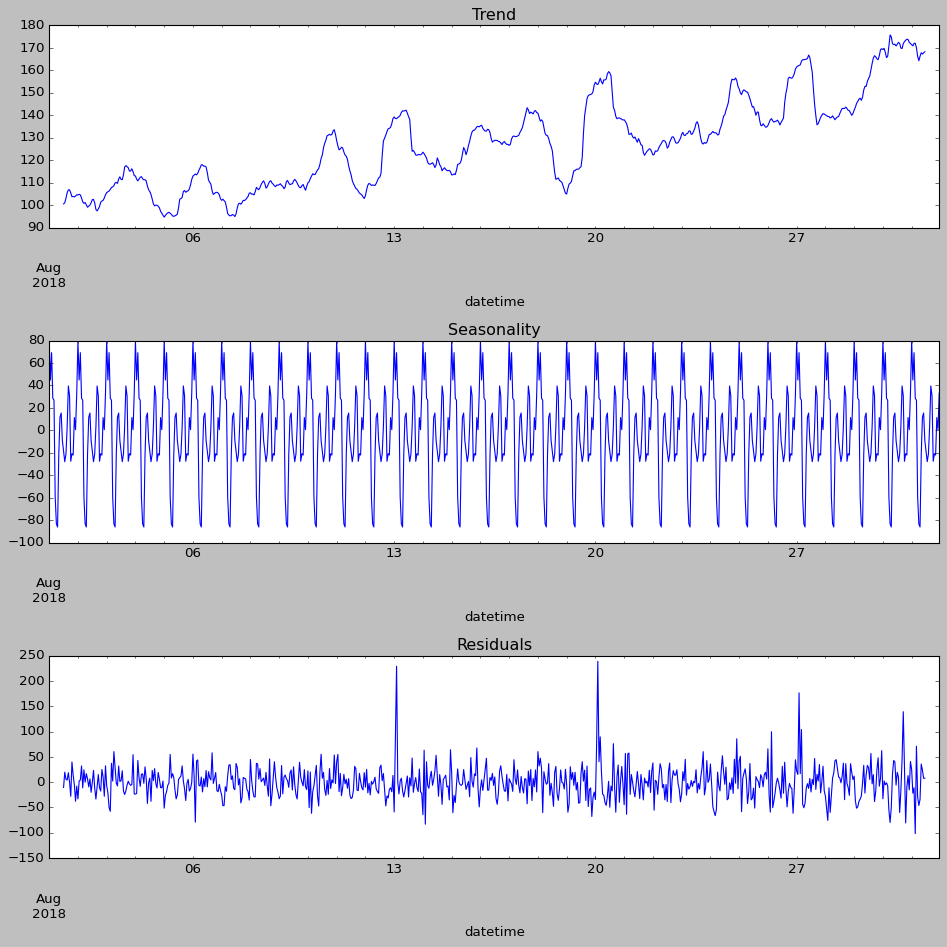

In [7]:
plt.style.use('classic')
decomposed = seasonal_decompose(dataxi['2018-08':'2018-08'])
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Residuals')
plt.tight_layout()

Распределение сезонной части выглядит статическим в интервале суток. Ночью такси почти не заказывают, пик ближе к вечеру.
Случайная часть также имеет постоянной среднее значение, но периодически возникают большие выбросы (выходные и праздники)
Трэнд показывает линейный рост количества заказов со временем. Построим тренд для всего временного ряда, чтобы увидеть полную картину.

Text(0.5, 1.0, 'Trend')

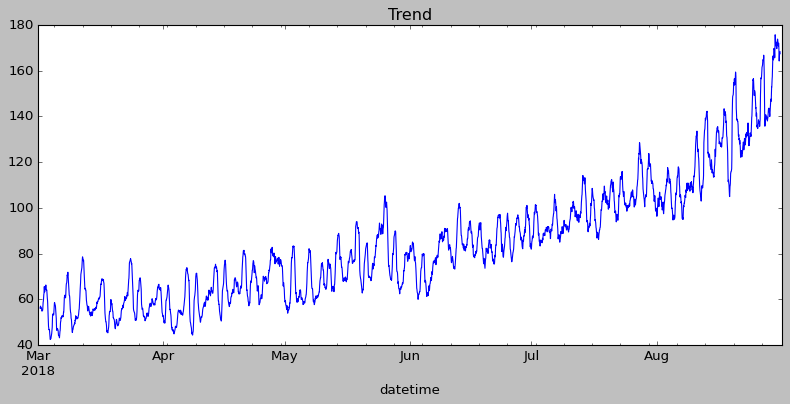

In [8]:
plt.style.use('classic')
decomposed = seasonal_decompose(dataxi)
plt.figure(figsize=(12, 5))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

Тренд имеет более сложную зависимость от времени. Нам нужны всего на час вперёд.
Также заметим, что линия тренда имеет некоторый шум. Возможно, для предсказания будет необходимо применить скользящее среднее с окном в несколько часов.

## 3. Обучение

### 3.1. Подготовка признаков

In [9]:
RANDOM_STATE = 12345
tss = TimeSeriesSplit(n_splits=5)

### 3.2. Разбивка на выборка и проверка константной модели

Напишем функцию для создания обучающих признаков и одновременного создания обучающей (90% данных) и тестовой выборок. Добавим  признаки day, dayofweek, hour. А также признаки для скользящего среднего rolling_mean (с размером окна rolling_mean_size), и смещения (lag_i) для признаков отстающего значения.

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)
    train = train.dropna()
    features_train = train.drop('num_orders', axis = 1)
    target_train = train['num_orders']
    features_test = test.drop('num_orders', axis = 1)
    target_test = test['num_orders']
    
    return features_train, target_train, features_test, target_test

In [11]:
def model_results(model, parameters):
    gscv = GridSearchCV(model, param_grid=parameters, cv=tss,
                        scoring='neg_root_mean_squared_error', n_jobs=-1)
    gscv.fit(features_train, target_train)
    rmse = -(gscv.best_score_)
    return gscv, rmse

In [15]:
features_train, target_train, features_test, target_test = make_features(dataxi, 24, 24)

In [16]:
model_dr = DummyRegressor()
model_dr.get_params().keys()

dict_keys(['constant', 'quantile', 'strategy'])

In [17]:
%%time
dr_parameters = {'strategy': ['mean', 'median']}
dummy_regressor = model_results(model_dr, dr_parameters)

CPU times: total: 109 ms
Wall time: 9.47 s


In [19]:
print(f"RMSE: {round(dummy_regressor[1], 2)}")

RMSE: 40.5


### 3.3. Обучение линейных регрессий.

In [20]:
model_lr = LinearRegression()
model_lr.get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'positive'])

In [21]:
%%time
lr_params = dict(fit_intercept = [True, False], positive = [True, False])
l_regressor = model_results(model_lr, lr_params)

CPU times: total: 141 ms
Wall time: 685 ms


In [25]:
display(l_regressor[0].best_params_)
print(f"RMSE: {round(l_regressor[1], 2)}")

{'fit_intercept': False, 'positive': True}

RMSE: 27.1


In [26]:
model_lasso = Lasso()
model_lasso.get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start'])

In [27]:
%%time
model_lasso = Lasso(random_state=RANDOM_STATE)
lasso_params = dict(alpha = [0.1, 0.2, 0.5, 1], max_iter = [10, 20])
lasso_regresson = model_results(model_lasso, lasso_params)

CPU times: total: 219 ms
Wall time: 1.43 s


In [30]:
display(lasso_regresson[0].best_params_)
print(f"RMSE: {round(lasso_regresson[1], 2)}")

{'alpha': 1, 'max_iter': 20}

RMSE: 27.11


In [31]:
model_ridge = Ridge()
model_ridge.get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'positive', 'random_state', 'solver', 'tol'])

In [32]:
%%time
model_ridge = Ridge(random_state=RANDOM_STATE)
ridge_params = dict(alpha = [0.1, 0.2, 0.5, 1], max_iter = [10, 20])
ridge_regresson = model_results(model_ridge, ridge_params)

CPU times: total: 203 ms
Wall time: 589 ms


In [33]:
display(ridge_regresson[0].best_params_)
print(f"RMSE: {round(ridge_regresson[1], 2)}")

{'alpha': 1, 'max_iter': 10}

RMSE: 27.15


### 3.3. Перейдём к более сложным регрессиям **DecisionTree**, **LGBM**, **CatBoost**

In [34]:
model_lgbm = LGBMRegressor()
model_lgbm.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [35]:
%%time
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)
lgbm_params = dict(n_estimators = [50, 100], max_depth = [5, 10], learning_rate = [0.1, 0.2])
lgbm_regresson = model_results(model_lgbm, lgbm_params)

CPU times: total: 844 ms
Wall time: 11 s


In [36]:
display(lgbm_regresson[0].best_params_)
print(f"RMSE: {round(lgbm_regresson[1], 2)}")

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

RMSE: 24.83


In [37]:
model_dtr = DecisionTreeRegressor()
model_dtr.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [38]:
%%time
model_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)
dtr_params = dict(max_depth = [10, 20, 50, 100], min_samples_split = [5, 10])
dtr_regresson = model_results(model_dtr, dtr_params)

CPU times: total: 547 ms
Wall time: 2.85 s


In [39]:
display(dtr_regresson[0].best_params_)
print(f"RMSE: {round(dtr_regresson[1], 2)}")

{'max_depth': 10, 'min_samples_split': 10}

RMSE: 32.88


In [40]:
%%time
model_cbt = CatBoostRegressor(random_state=RANDOM_STATE)
cbt_params = dict(iterations = [50, 100], depth = [5, 10], learning_rate = [0.1, 0.2])
cbt_regresson = model_results(model_cbt, cbt_params)

0:	learn: 35.3074156	total: 159ms	remaining: 15.7s
1:	learn: 32.7688471	total: 173ms	remaining: 8.5s
2:	learn: 30.9487411	total: 186ms	remaining: 6.01s
3:	learn: 29.3322878	total: 198ms	remaining: 4.76s
4:	learn: 28.0781127	total: 214ms	remaining: 4.07s
5:	learn: 27.0603665	total: 229ms	remaining: 3.59s
6:	learn: 26.4055847	total: 243ms	remaining: 3.23s
7:	learn: 25.7522249	total: 261ms	remaining: 3s
8:	learn: 25.1816205	total: 274ms	remaining: 2.77s
9:	learn: 24.8233099	total: 295ms	remaining: 2.66s
10:	learn: 24.5639007	total: 308ms	remaining: 2.49s
11:	learn: 24.1659021	total: 324ms	remaining: 2.37s
12:	learn: 23.8660184	total: 339ms	remaining: 2.27s
13:	learn: 23.7248163	total: 353ms	remaining: 2.17s
14:	learn: 23.6662962	total: 382ms	remaining: 2.16s
15:	learn: 23.4781417	total: 396ms	remaining: 2.08s
16:	learn: 23.4448620	total: 414ms	remaining: 2.02s
17:	learn: 23.2461153	total: 427ms	remaining: 1.94s
18:	learn: 23.1167189	total: 443ms	remaining: 1.89s
19:	learn: 22.9678095	tota

In [41]:
display(cbt_regresson[0].best_params_)
print(f"RMSE: {round(cbt_regresson[1], 2)}")

{'depth': 5, 'iterations': 100, 'learning_rate': 0.2}

RMSE: 24.69


У CatBoost RMSE чуть получше, чем у LGBM но скорость выполнения запределеьно долгая!!!

In [46]:
Models = pd.DataFrame([l_regressor[1], lasso_regresson[1], ridge_regresson[1], 
                       dtr_regresson[1], lgbm_regresson[1], cbt_regresson[1]], 
                      columns=['RMSE'], 
                      index=[f'Linear {l_regressor[0].best_params_}', f'Lasso {lasso_regresson[0].best_params_}',
                             f'Ridge {ridge_regresson[0].best_params_}', f'DecisionTree {dtr_regresson[0].best_params_}',
                             f'LGBM {lgbm_regresson[0].best_params_}', f'CatBoost {cbt_regresson[0].best_params_}'])
Models

,RMSE
"Linear {'fit_intercept': False, 'positive': True}",27.096911
"Lasso {'alpha': 1, 'max_iter': 20}",27.106397
"Ridge {'alpha': 1, 'max_iter': 10}",27.148059
"DecisionTree {'max_depth': 10, 'min_samples_split': 10}",32.875429
"LGBM {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}",24.831308
"CatBoost {'depth': 5, 'iterations': 100, 'learning_rate': 0.2}",24.694430


**Вывод:**
- Все модели справились с ТЗ
- Самая быстрая и довольно точная - **LGBM**
- CatBoost сильно уступил LGBM по времени анализа!!!

## 4. Тестирование

Для предсказаний модели **LGBM, CatBoost** и целевого признака построим графики зависимостей от времени. Проверим, в какие моменты модель была более точной и менее точной.

In [47]:
lgbm_regresson[0].fit(features_train, target_train)
lgbm_preds = lgbm_regresson[0].predict(features_test)
lgbm_rmse = mse(target_test, lgbm_preds)**0.5
print(f'RMSE LGMB на тестовой выборке: {round(lgbm_rmse, 2)}')
lgbm_preds = pd.Series(lgbm_preds.astype(int), 
                       index = target_test.index, name='LGBM prediction')

cbt_regresson[0].fit(features_train, target_train)
cbt_preds = cbt_regresson[0].predict(features_test)
cbt_rmse = mse(target_test, cbt_preds)**0.5
print(f'RMSE CatBoost на тестовой выборке: {round(cbt_rmse, 2)}')
cbt_preds = pd.Series(cbt_preds.astype(int), 
                      index = target_test.index, name='CatBoost prediction')

predictions = pd.concat([target_test, lgbm_preds, cbt_preds], axis=1)
predictions.head(10)

RMSE LGMB на тестовой выборке: 41.77
0:	learn: 35.3074156	total: 18.9ms	remaining: 1.87s
1:	learn: 32.7688471	total: 35.9ms	remaining: 1.76s
2:	learn: 30.9487411	total: 50.7ms	remaining: 1.64s
3:	learn: 29.3322878	total: 65.1ms	remaining: 1.56s
4:	learn: 28.0781127	total: 80.1ms	remaining: 1.52s
5:	learn: 27.0603665	total: 97.1ms	remaining: 1.52s
6:	learn: 26.4055847	total: 112ms	remaining: 1.49s
7:	learn: 25.7522249	total: 128ms	remaining: 1.47s
8:	learn: 25.1816205	total: 150ms	remaining: 1.51s
9:	learn: 24.8233099	total: 178ms	remaining: 1.6s
10:	learn: 24.5639007	total: 193ms	remaining: 1.56s
11:	learn: 24.1659021	total: 208ms	remaining: 1.53s
12:	learn: 23.8660184	total: 226ms	remaining: 1.51s
13:	learn: 23.7248163	total: 267ms	remaining: 1.64s
14:	learn: 23.6662962	total: 289ms	remaining: 1.64s
15:	learn: 23.4781417	total: 304ms	remaining: 1.59s
16:	learn: 23.4448620	total: 318ms	remaining: 1.55s
17:	learn: 23.2461153	total: 347ms	remaining: 1.58s
18:	learn: 23.1167189	total: 362

,num_orders,LGBM prediction,CatBoost prediction
datetime,,,
2018-08-13 14:00:00,102,92,99
2018-08-13 15:00:00,175,109,109
2018-08-13 16:00:00,144,155,139
2018-08-13 17:00:00,152,135,143
2018-08-13 18:00:00,104,111,126
2018-08-13 19:00:00,91,96,93
2018-08-13 20:00:00,82,101,104
2018-08-13 21:00:00,160,107,109
2018-08-13 22:00:00,104,143,120


<Axes: xlabel='datetime', ylabel='num_orders'>

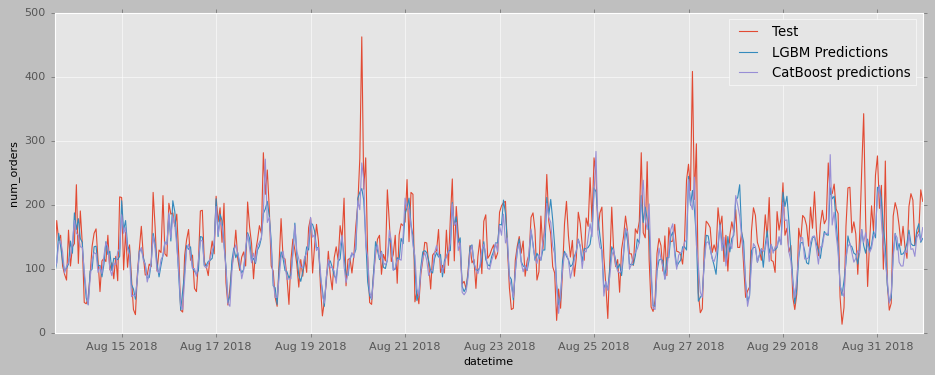

In [48]:
plt.figure(figsize=(14, 5))
plt.style.use('ggplot')
sns.lineplot(x=predictions.index, y=predictions['num_orders'], label='Test')
sns.lineplot(x=predictions.index, y=predictions['LGBM prediction'], label='LGBM Predictions')
sns.lineplot(x=predictions.index, y=predictions['CatBoost prediction'], label='CatBoost predictions')

**Выводы:**
- Модель LGBM достаточно точно определяет ежедневно повторяющиеся паттерны в тестовых данных и делает это быстро. 
- RMSE test у CatBoost больше чем у LGBM, да еще и рассчёт идет на порядок медленнее!!! 
- Резкие пики спроса на такси обе модели предсказать не могут. 

## 5. Выводы

- Все линейные модели показали похожий результат по RMSE.
- По графику видно, что лучшая модель **LGBM** достаточно точно предсказывет данные. Однако резкие пики в данных предсказать не может.